In [6]:
##### #03/22/2023 Xilin found out it used the last min_action no matter what - revised it
import scipy
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run Helpers.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
import itertools


## Mathmatic Functions

In [61]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A,op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean) 
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

def obj_polarization_1(A, L, op, n):
    z = np.dot(A, op) 
    z_mean = mean_center(z, n)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

In [62]:
# Parameters for the network
np.set_printoptions(precision=3)
n = 20

## Creating Network
### 1. Make Random Network

In [63]:
def create_erdos_renyi_network(n, p, u, v):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
#         for j in range(i+1,n):
#             r = np.random.rand()
#             if r < p:
            if j<i:
                A[i,j] = A[j,i] = 1
#             if i==u or i==v:
#                 A[i,j] = A[j,i] = 1
    return A


def make_innat_opinions(n): # Make opinion for agents only - no info source is involved
    
    # Make list of ind innate opinion to define info source opinion
    innat_s = np.random.uniform(low=0, high=1, size=int(n))   #individual's innate opinion 

    s = np.zeros((n, 1))
    
    idx1 = 0
    for i in range(len(s)):
        s[i] = innat_s[idx1]  #set innate opinion for ind.
        idx1 += 1
  
    return s

def make_random_network(n):
    # Create empty graph
    nxG = nx.Graph()
    # Add nodes to graph
    nxG.add_nodes_from(range(n))
    # Add edges based on node index
    for i in range(n):
        for j in range(i):
            p = (n-i)/(n-j) # Probability of edge existing
            if np.random.random() < p:
                nxG.add_edge(i, j)

    # Draw graph
#     nx.draw(nxG, with_labels=True)
#     plt.show()
    G = nx.adjacency_matrix(nxG).todense()
    
    return G



In [64]:
def visualize(s,G):
    # what the twitter graph looks like 
    s_use = s.flatten()   # Convert array to a list for later operation
    s_use = s_use.tolist()
    new_s = [i * 30 for i in s_use]
    df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2

    nxG = nx.from_numpy_matrix(G)   
   
    #plt.figure(figsize=(10, 10))
        ##### Calculate Key Values  ######
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    columnsum_ij = np.sum(A, axis=0)
    m = num_edges(L, n)                    # call the function to calculate the number of edges

#     print(n)
    # what the twitter graph looks like 

    def node_edge(G, n):
        edges =[]
        for v in range(n):
            a = np.array(np.nonzero(G[v])[0])
            edge = len(a)
    #         print(edge)
            edges.append(edge)

        return edges

    node_edges = node_edge(G, n)
    # print(node_edges)

    node_sizes =[]
    for i in node_edges:
        node_size = 1/i*8000
        node_sizes.append(node_size)
        
#     plt.figure(figsize=(20, 20))

    # Fix seed - fix network shape
    my_pos = nx.spring_layout(nxG, seed = 2)
    nx.draw(nxG, pos= my_pos, with_labels= True, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
    #nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
    cbar = plt.colorbar(sm, shrink = 0.5)
    tick_font_size = 24
    cbar.ax.tick_params(labelsize=tick_font_size)
   # plt.show()
    


# if we want to customize the color bar range to min/max s
# vmin = min(s)
# vmax = max(s)
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.5)
# plt.show()

### Min [245, ] [284, ]       Max [50, ] [481, ] 

### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [65]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, s, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)

### Testing players' behavior

In [68]:
# Row are Column are depended on min and max's choice: agent v and opinion 
def row_index(v2, min_opinion):
    row = 11*v2 + min_opinion*10 
    return int(row)
def column_index(v1,max_opinion):
    column = 2*v1 + max_opinion
    return int(column)  #the python dataframe index

def random_play(s,n):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
  
    v = random.randint(0,n-1)  # randomly select an agent index
    new_op = random.randint(0, 1)  # randomly select an opininon between 0 and 1)
    
    # Store old opinion
    old_opinion = op[v,0]
    
    #update the opinion
    op[v,0] = new_op 
    por = obj_innate_polarization(op, n)
    print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    
    #restore op op array to innate opinion
    op[v] = old_opinion
#     print("Network reaches equilibrium Polarization: " + str(por))
    return (v, new_op, por)

def random_play1(s,n):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)  
    v = random.randint(0,n-1)  # randomly select an agent index
    new_op = random.uniform(0, 1)  # randomly select an opininon between 0 and 1
    
    # Store old opinion
    old_opinion = op[v,0]
    
    #update the opinion
    op[v,0] = new_op 
    print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
#     por = obj_polarization(A, op, n)
    por = obj_innate_polarization(op, n)
    #restore op op array to innate opinion
    op[v] = old_opinion
#     print("Network reaches equilibrium Polarization: " + str(por))
    return (v, new_op, por)

def make_payoff_row(op1,v2,G):
    payoff_row = np.zeros(2*n)
    for column in range(2*n):
#         print(column)
        v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
        max_opinion = column%2
        # update the maximizer's change to the opinion array that has changed by minimizer(op1)
        op2 = copy.copy(op1)
#         temp = op1[v1]
        op2[v1,0] = max_opinion
        # calculate the polarization with both max and min's action
        L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
        A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
        payoff_row[column] = obj_polarization(A, op2, n)

    # when v1 == v2, the polarization should be negative for max, infinet for min. 
    # Replace the the column_index of agent v2 with 0 for max
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    payoff_row[j_1] = -100
    payoff_row[j_2] = -100
    
    return payoff_row


# Calculate polarization of minimizer's Mixed Strategy
def mixed_min_polarization(s,v2,weight_op,fla_max_fre, G):

    op1 =  copy.copy(s) # make a copy of the innate opinion array 
    op1[v2,0] = weight_op # then only updated by minimizer's current change
    # calculate the polarization with both min(did here) and max's action(in make_payoff_row)
    payoff_row = make_payoff_row(op1,v2,G)  # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
    #print(payoff_row)

    # Replace the the column_index of agent v2 with 100 for min
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    payoff_row[j_1] = 100
    payoff_row[j_2] = 100

    #calculate fictitious payoff - equi_min  
    payoff_cal = payoff_row * fla_max_fre # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1   
    mixed_pol = np.sum(payoff_cal) # add up all, calculate average/expected payoff
    # Replace the the column_index of agent v2 with 100 for min

    payoff_row[j_1] = -100
    payoff_row[j_2] = -100

    return (mixed_pol,payoff_row)

def derivate_s(op,n,v2,G):
               #op - opinion array that updated by maximizer
    c = [1/n] * n
#     print(c)
    sum_term = 0
    j = 0
        ##### Calculate Key Values  ######
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    
    sum_term = np.dot(np.dot((A-c),(A[v2]-c)),op)  # sum up all terms
    
    term_out = op[v2]*np.dot((A[v2]-c),(A[v2]-c)) # exclude the term that j = v2
    sum_s = sum_term - term_out    # numerator
    
    s_star = -sum_s/np.dot((A[v2]-c),(A[v2]-c))
    s_star = s_star[0] #take value out of array
    min_opinion =min(max(0,s_star),1)
    return min_opinion
    
    
def min_mixed_opinion_1(s, n, v2, fla_max_fre,A):
    
    weight_op = 0
    # loop for each max_action(in total 2*n) 
    for column in range(2*n):

        if fla_max_fre[column] !=0:
            v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
            max_opinion = column%2
            op = copy.copy(s)
            op[v1] = max_opinion
            min_opinion = derivate_s(op, n, v2,G)# find min_s_star for each max_action
            op1 = copy.copy(op)
            op1[v2] = min_opinion   #after max action, update min action on opinion array
            min_por = obj_polarization(A, op1, n)
            t = 0  
            weight_op = weight_op + fla_max_fre[column]*min_opinion # sum up p_i*s_i

  
    (mixed_por, payoff_row) = mixed_min_polarization(s, v2, weight_op,fla_max_fre, G)
#     print('Weighted polarization')
#     print(mixed_por)

    return(weight_op,payoff_row,mixed_por)  


def mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre,A):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = copy.copy(s)
    op[v1,0] = max_opinion
#     print('Check if op has been updated by Maximizer')
#     print(op)
    min_por = 1000 #min_por- set a standard to compare with pol after min's action
    maxup_por = obj_polarization(A, op, n)# store innate max updated polarization
    champion = (None, None, 0, None)  # assume the best action is champion

    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x not in max_touched]  # for the vertice that Maximizer has not touched
    
    for v2 in C1:   
#         print('_________________________________')
#         print('Min start with agent '+ str(v2) )
        (changed_opinion, payoff_row, por) =  min_mixed_opinion_1(s, n, v2, fla_max_fre,A) # find the best new_op option           
#         print('changed opinion, por, Maxup_por')
#         print(changed_opinion, por, maxup_por)
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por # update the recent option as champion
            champion = (v2, changed_opinion, payoff_row, min_por)  

    return (champion)  # find the best minimizer's action after going through every new_op option of every agent

####Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
def mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre,A): 

    print('_______________________')
    print('Minimizer Play')
    
    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre,A)
    (v2, min_opinion, payoff_row, min_pol) = min_champion
    
    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")

        # Store innate_op of the min_selected vertex
        op = copy.copy(s)
        old_opinion_min = op[v2,0]

        print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
        print('fla_max_fre')
        print(np.nonzero(fla_max_fre))
        print(fla_max_fre [np.nonzero(fla_max_fre)])
    return (v2, payoff_row, min_opinion, min_pol)                 


####Op has been updated by minimizer, fla_min_fre includes min's hisotry, so maxmizer react to the innate op after that
def mixed_max_polarization(payoff_matrix,v1,max_opinion,fla_min_fre):

    # create payoff matrix for maxmizer
    column = int(column_index(v1,max_opinion))
    payoff_vector = payoff_matrix[:,column]
    #calculate fictitious payoff - equi_max   
    payoff_cal = payoff_vector * fla_min_fre #payoff * frequency
    mixed_pol = np.sum(payoff_cal) # add up
    return mixed_pol


# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre):
    
    por_arr = np.zeros(2)  # create a two_element array to store polarization value of each option
    max_opi_option = [0, 1.0]   # Maximizer has two options to change agent v1's opinion
    
    # objective if set opinion to 0, 1.0
    j = 0
    for new_op in max_opi_option:
#         print('change op to '+ str(i/10))
        max_opinion = new_op
        por_arr[j] = mixed_max_polarization(payoff_matrix,v1,max_opinion, fla_min_fre)
        j = j + 1   # index increase 1, put the polarization in array
    
    maxmize_op = np.argmax(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
    max_por = np.max(por_arr)        # find the maximum polarization in the record
    return (maxmize_op, max_por)

# determine which agent maximizer should select to maximizer the equilibrium polarization
def mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre, A):
    
    max_por = obj_polarization(A, op, n)  # use "innate"(after min action) polarization as a comparable standard to find max_por
    minup_por = max_por # store innate min_update polarization
    champion = (None, None, max_por)  # assume champion is the best action

    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x not in min_touched]  # for the vertice that Minimizer has not touched
    for v1 in C1:  
            (changed_opinion, por) = max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre)
            if por > max_por: # if the polarization of most recent action > maximum polarization of previous actions
                max_por = por
                champion = (v1, changed_opinion,max_por)   # save the this action as champion    
    return (champion)

def mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre, A): 
    op = copy.copy(s)   # op is a copy of innate opinion
    
    #update innat opinion 
    op[v2,0] = min_opinion  # Op has been updated by minimizer, so maximizer react to the innate op after that
    max_champion = mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre, A) # The best choice among all opinions and vertexs
    (v1, max_opinion, max_pol) = max_champion

    if v1 == None:
        print('Maximizer fail')
    else:
        print("                                ")
        print("Maximizer finds its target agent:")
        #Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        
        ## check if agent's opinionis is changed or not
        print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))

    return(v1, max_opinion, max_pol)

def push(obj, element):
    if len(obj) >= memory:
        obj.pop(0)
        print('pop')
    obj.append(element)
    return obj

def all_fre_limited_touch(s, n, G, Game_rounds, memory):
    # Preparation for the game
    op = copy.copy(s)
    payoff_matrix = np.empty((0, 2*n), float)
    max_history = np.zeros([n, 2])  # n*2 matrix, agent i & opinion options
    min_history = []  # append a list of (agent i, min_opinion), min_opinion can be any value
#     print(type(min_history))

    max_history_last_100 = np.zeros([n, 2]) 
    min_history_last_100= []

    max_touched = []
    min_touched = []
    min_touched_all = []
    min_touched_last_100 =[]
    print('min_touched')
    print(min_touched)
    
    
    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory

    # Game start from maximizer random play
    print('Maximizer first selection')
    (v1, max_opinion, max_pol) = random_play(op,n)   # Maximizer does random action 
    #(v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)
    First_max = (v1, max_opinion, max_pol) 
#     (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,max_touched)

    # Maximizer start with greedy play
    # (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)   # Maximizer choose action greedily
    max_touched.append(v1)    # save Maximizer's action history

    # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
    max_history[v1,int(max_opinion)] = max_history[v1,int(max_opinion)] +1

    print('history at spot')
    print(max_history[v1,int(max_opinion)])

    max_frequency = max_history/1  # its frequency, only played  1 time so far, divided by 1 
    # print('fre_max at spot')
    # print(max_frequency[v1,int(max_opinion)])

    fla_max_fre = max_frequency.flatten()   # flatten the n*2 matrix to a 2n*1 matrix
                                            # so we can multiply the freuency (2n*1)with payoff array (1*2n) 
                                            # to get average payoff of fictitious play
    print('fre_max at spot')
    print(fla_max_fre)

    column = int(column_index(v1,max_opinion))    # the frequency of maximizer's most recent action (v1,max_opinion)

    print(fla_max_fre[column])

    # if game start from minimizer random play - make sure two random play are not same agent!!!
    print('Minimizer first selection')
    (v2, min_opinion, min_pol) = random_play(op,n) 
    #(v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)
    
    #(v2, min_opinion, min_pol) = (29, 1, 0.5933309600094931)
    First_min = (v2, min_opinion, min_pol)

    if v1==v2:   # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
        sys.exit()

    # Minimizer start with greedy play
    # (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)

    min_touched.append(v2)
   

    # store minimizer play history
    min_history.append((v2,min_opinion))
    print('min_history')
    print(min_history)


    counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
    print(counter)
    fla_min_fre = np.array(list(counter.values()))/1 #return only frequency of all min options in order

    (a,payoff_row) = mixed_min_polarization(s,v2,min_opinion,fla_max_fre,G)
    payoff_matrix = np.vstack([payoff_matrix, payoff_row])

    print('fla_min_fre at the spot')
    min_counter = dict(counter)
    print(min_counter) 
    print(min_counter[(v2,min_opinion)]) 
    equi_min = min_pol
    equi_max = max_pol


    Flag = 0

    i = 0
    while Flag == 0: 
        i = i + 1
        print("Game " + str(i))
        print("_____________________")

    #     if max_pol == min_pol:
        if i == Game_rounds:            # i == # of iterations you want to run + 2
                                # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
            print('min_recent_'+str(memory)+'_touched')# then stop at Game 202
            print(min_touched)
            print('max_recent_'+str(memory)+'_touched')
            print(max_touched)
            print('Min last 100 action')
            print(min_touched_last_100)

            break

        elif equi_min == equi_max:
            print("Reached Nash Equilibrium at game"+ str(i) + "and Equi_Por = " + str(equi_min))
            print('max_distribution')
            print(max_frequency)
            print('min_distribution')
            print(fla_min_fre)
            Flag = 1
            break
        ############################## maximizer play  
        else:
            if i == Game_rounds-100:    #if Game_round = 200, after 100 iteration, Game 101 print previous historical result
    # Remove max frequncy less than 0.1--
                max_history_last_100 = np.zeros([n, 2]) 
                min_history_last_100 = [] 
                min_touched_last_100 =[]

            (v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre, A)
            max_touched = push(max_touched, v1)

            max_history[v1,int(max_opinion)] = max_history[v1,int(max_opinion)] +1

            max_history_last_100[v1,int(max_opinion)] = max_history_last_100[v1,int(max_opinion)] +1
    #         print('max_history')
    #         print(max_history)
    #________________________________________________________________
            max_frequency = max_history/(i+1)  # its frequency 
    #         print('max_distribution')
    #         print(max_frequency)
        #     print(i+1) 
            fla_max_fre = max_frequency.flatten() #flaten max_frequency to calculate average payoff
#             print('fla_max_fre')
#             print(fla_max_fre)
            print('fre_max at spot')
            print(fla_max_fre[column])
            # create payoff matrix for maxmizer
            row = int(row_index(v2, min_opinion))
            column = int(column_index(v1,max_opinion))

    ############################### minimizer play
            (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre,A)
            min_touched = push(min_touched, v2)
            min_touched_all.append(v2) 
            min_touched_last_100.append(v2)

            if (v2,min_opinion) in counter.keys():
                payoff_matrix = payoff_matrix # if this min_option is in min_history, no need to update paryoff matrix, only update frequency
                print("Same history")
                print((str(v2),str(min_opinion)))
            else:
                payoff_matrix = np.vstack([payoff_matrix, payoff_row]) # if this is a new option, append to previous matrix
            min_history.append((v2,min_opinion))
            min_history_last_100.append((v2,min_opinion))

            counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}

            fla_min_fre = np.array(list(counter.values()))/(i+1) #return only frequency of all min options in order

            # create payoff matrix for minimizer
            row = row_index(v2, min_opinion)
            column = column_index(v1,max_opinion)
            print("Not Reached Nash Equilibrium at Equi_Min = " + str(equi_min) + " and Equi_Max = "+ str(equi_max)) 
    return (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100)


def result(max_history_last_100, min_touched_last_100):
    # MAXimizer's distribution of LAST 100 iteration 
    print('Max_distribution_last_100')  
    max_l100_fre = max_history_last_100/100
    print(max_l100_fre [np.nonzero(max_l100_fre)])
    print(np.nonzero(max_l100_fre)[0])
    v1 = np.nonzero(max_l100_fre)[0]

    # MINimizer's Strategy in the last 100 round
    print('Min_distribution_last_100')
    counter_h=collections.Counter(min_touched_last_100)  #return a dictionary include {'min_option': count of this choice}
    print(counter_h.keys())
    v2 = set(counter_h.keys())
    
    return(v1,v2)


### Minimizer Strategy

In [74]:
# (v1,v2,max_pol) = MaxMin_play(s,n)
def run(n):
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (a,b,c,d)= net_rank(s,G)
    #   visualize(s,G)
    Game_rounds =100 # Rounds + 1- use for printing data
    memory = 50
    (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100) = all_fre_limited_touch(s, n, G, Game_rounds, memory)
    (v1,v2) = result(max_history_last_100, min_touched_last_100)
    return (v1,v2,a,b,c,d)


## Network Analysis

In [84]:
def net_rank(s,G):
    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    #print("_______________Degree Centrality_____________________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    # print(converted_dict)
    #print("                           ")
    #print("_______________Closeness Rank_____________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    # print(converted_dict1)
    #print("                           ")
    #print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict2 = dict(sortedDict2)
    # print(converted_dict2)

    #print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return abs(x)

    gap = gap(s,n)
    my_gap = {index: value for index, value in enumerate(gap)}
    sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
    sorted_gap = dict(sorting_gap)
    #print(sorted_gap)
    return (converted_dict,converted_dict1,converted_dict2,sorted_gap)

def pred(N,converted_dict,converted_dict1,converted_dict2,sorted_gap):
    # Using islice() + items()
    # Get first N items in dictionary
    a = list(itertools.islice(converted_dict.keys(), N))
    b = list(itertools.islice(converted_dict1.keys(), N))
    c = list(itertools.islice(converted_dict2.keys(), N))


    max_pred = sorted(np.unique(a+b+c))
#     print("Max limited by K is : " + str(max_pred))
    min_pred = list(itertools.islice(sorted_gap.keys(), N))
    # printing result
#     print("Min limited by K is : " + str(min_pred))
    
    return (max_pred, min_pred)



    


In [85]:
# def net_rank(s,G):
#     #print("___________________Max Analyze__________________________________________")
#     nxG = nx.from_numpy_matrix(G) 
#     # G = nx.karate_club_graph()
#     #print("_______________Degree Centrality_____________________________")  
#     deg_centrality = nx.degree_centrality(nxG)
#     sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
#     converted_dict = dict(sortedDict)
#     # print(converted_dict)
#     #print("                           ")
#     #print("_______________Closeness Rank_____________________________")
#     close_centrality = nx.closeness_centrality(nxG)
#     sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
#     converted_dict1 = dict(sortedDict1)
#     # print(converted_dict1)
#     #print("                           ")
#     #print("_______________Page Rank_____________________________")
#     pr = nx.eigenvector_centrality(nxG)
#     sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
#     converted_dict2 = dict(sortedDict2)
#     # print(converted_dict2)

#     #print("                           ")

#     def gap(op, n):
#         ones = np.ones((n, 1))
#         x = op - (np.dot(np.transpose(op),ones)/n) * ones
#         return abs(x)

#     gap = gap(s,n)
#     my_gap = {index: value for index, value in enumerate(gap)}
#     sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
#     sorted_gap = dict(sorting_gap)
#     #print(sorted_gap)
#     return (converted_dict,converted_dict1,converted_dict2,sorted_gap)

# def pred(N,converted_dict,converted_dict1,converted_dict2,sorted_gap):
#     # Using islice() + items()
#     # Get first N items in dictionary
#     a = list(itertools.islice(converted_dict.keys(), N))
#     b = list(itertools.islice(converted_dict1.keys(), N))
#     c = list(itertools.islice(converted_dict2.keys(), N))
    
#     max_pred = c

#     #max_pred = sorted(np.unique(a+b+c))
# #     print("Max limited by K is : " + str(max_pred))


#     #print("*********opinion*************")
#     rank1_list = list(range(n))
#     #print(rank1_list)
#     op_order = sorted_gap.keys()
#     #print(sorted_gap)
#     op_ranks= dict(zip(op_order, rank1_list))
#     #print(op_ranks)

#     #print("*********centrality*************")
#     ecen_order = converted_dict2.keys()
#     #print(ecen_order)
#     ecen_ranks=dict(zip(ecen_order, rank1_list))
#     #print(converted_dict2)
#     #print(ecen_ranks)

#     #print("*********new ranks*************")      
#     new_rank = {i: 0.5*op_ranks.get(i, 0) + 0.5*ecen_ranks.get(i, 0) for i in set(op_ranks).union(ecen_ranks)}
#     #print(new_rank)
#     sorting_rank = sorted(new_rank.items(), key=lambda x:x[1])
#     sorted_rank = dict(sorting_rank)
# #     print(sorted_rank)
#     min_pred1= list(itertools.islice(sorted_rank.keys(), N))
    
#     first_key = next(iter(converted_dict2)) 
#     converted_dict2.pop(first_key)
#     min_pred2= list(itertools.islice(converted_dict2.keys(), N))
    
#     min_pred = min_pred1 + min_pred2
# #     print(min_pred)

#     # printing result
# #     print("Min limited by K is : " + str(min_pred))
    
#     return (max_pred, min_pred)



In [139]:
(v1,v2,a,b,c,d) = run(n)                    


min_touched
[]
Maximizer first selection
    Agent3 's opinion 0.6842418254088685 changed to 0
history at spot
1.0
fre_max at spot
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
Minimizer first selection
    Agent17 's opinion 0.24048185019006352 changed to 0
min_history
[(17, 0)]
Counter({(17, 0): 1})
fla_min_fre at the spot
{(17, 0): 1}
1
Game 1
_____________________
                                
Maximizer finds its target agent:
    Agent18 's opinion 0.7845920227842521 changed to 0
fre_max at spot
0.5
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.2944275707411682
fla_max_fre
(array([ 6, 36], dtype=int64),)
[0.5 0.5]
Not Reached Nash Equilibrium at Equi_Min = 0.037116723644482354 and Equi_Max = 0.051932280930214736
Game 2
_____________________
                                
Maximizer fin

                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.45061231874105556
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.05 0.4  0.55]
Not Reached Nash Equilibrium at Equi_Min = 0.05085983489901369 and Equi_Max = 0.05200076772563234
Game 20
_____________________
                                
Maximizer finds its target agent:
    Agent18 's opinion 0.7845920227842521 changed to 0
fre_max at spot
0.42857142857142855
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.42915458927719574
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.048 0.429 0.524]
Not Reached Nash Equilibrium at Equi_Min = 0.05054453535328347 and Equi_Max = 0.0516764253197909
Game 21
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
fre_max at spo

                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.4470676309784586
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.026 0.41  0.564]
Not Reached Nash Equilibrium at Equi_Min = 0.05137776687542993 and Equi_Max = 0.05213715330772737
Game 39
_____________________
                                
Maximizer finds its target agent:
    Agent18 's opinion 0.7845920227842521 changed to 0
fre_max at spot
0.425
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.43589094020399716
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.025 0.425 0.55 ]
Not Reached Nash Equilibrium at Equi_Min = 0.051199739083972184 and Equi_Max = 0.05196565937885602
Game 40
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
fre_max at spot
0.414634

Not Reached Nash Equilibrium at Equi_Min = 0.051749277472341794 and Equi_Max = 0.05235160199777484
Game 55
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
pop
fre_max at spot
0.6071428571428571
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent16 's opinion 0.2014556818627249 changed to 0.6902385614883185
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.018 0.375 0.607]
pop
Not Reached Nash Equilibrium at Equi_Min = 0.0516509588374476 and Equi_Max = 0.05224087898461491
Game 56
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
pop
fre_max at spot
0.6140350877192983
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent16 's opinion 0.2014556818627249 changed to 0.693998553

Not Reached Nash Equilibrium at Equi_Min = 0.05180209862095652 and Equi_Max = 0.05228504103037757
Game 71
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
pop
fre_max at spot
0.6111111111111112
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent16 's opinion 0.2014556818627249 changed to 0.6911888792197525
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.014 0.375 0.611]
pop
Not Reached Nash Equilibrium at Equi_Min = 0.051724714488734586 and Equi_Max = 0.05219996317712612
Game 72
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 1
pop
fre_max at spot
0.6164383561643836
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent16 's opinion 0.2014556818627249 changed to 0.69411174

                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.4556639074781433
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.011 0.402 0.586]
pop
Not Reached Nash Equilibrium at Equi_Min = 0.051858546328312126 and Equi_Max = 0.05218452851321644
Game 87
_____________________
                                
Maximizer finds its target agent:
    Agent18 's opinion 0.7845920227842521 changed to 0
pop
fre_max at spot
0.4090909090909091
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent0 's opinion 0.9890270075814377 changed to 0.45048590852952813
fla_max_fre
(array([ 6, 36, 39], dtype=int64),)
[0.011 0.409 0.58 ]
pop
Not Reached Nash Equilibrium at Equi_Min = 0.05177461679170422 and Equi_Max = 0.052108926986924466
Game 88
_____________________
                                
Maximizer finds its target agent:
    Agent19 's opinion 0.29927996971193704 changed to 

[16, 18, 19] [0, 6, 2]
Maxs
Max predic right
Mins
Min predic right
{0: array([0.585]), 6: array([0.57]), 2: array([0.42]), 7: array([0.32]), 16: array([0.317]), 10: array([0.282]), 17: array([0.27]), 3: array([0.249]), 15: array([0.208]), 13: array([0.149]), 9: array([0.148]), 12: array([0.136]), 5: array([0.085]), 8: array([0.075]), 11: array([0.052]), 4: array([0.051]), 18: array([0.032]), 14: array([0.023]), 1: array([0.019]), 19: array([0.005])}


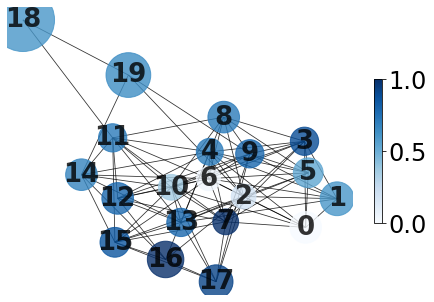

In [140]:
visualize(s,G)
N = 3
(converted_dict,converted_dict1,converted_dict2,sorted_gap) = net_rank(s,G)
(max_pred, min_pred) = pred(N,converted_dict,converted_dict1,converted_dict2,sorted_gap)

print(max_pred,min_pred)


print("Maxs")
if any(x in v1 for x in max_pred):
    print("Max predic right")
else:
    print("NNN")
    
print("Mins")
if any(x in v2 for x in min_pred):
    print("Min predic right")
else:
    print('NNN')
    v2 = random.sample(v2,1)
    print(v2)
    network_anl(s,n,G,v2[0])


# print("Predict Min's action")
# print(np.nonzero(G[v1]))
print(sorted_gap)

In [126]:
# s = make_innat_opinions(n)
def gap(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return abs(x)

gap = gap(s,n)
my_gap = {index: value for index, value in enumerate(gap)}
sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
sorted_gap = dict(sorting_gap)

# G = make_random_network(n)

nxG = nx.from_numpy_matrix(G) 
pr = nx.eigenvector_centrality(nxG)
sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
converted_dict2 = dict(sortedDict2)

print("*********opinion*************")
rank1_list = list(range(n))
#print(rank1_list)
op_order = sorted_gap.keys()
print(sorted_gap)
op_ranks= dict(zip(op_order, rank1_list))
print(op_ranks)

print("*********centrality*************")
ecen_order = converted_dict2.keys()
print(ecen_order)
ecen_ranks=dict(zip(ecen_order, rank1_list))
print(converted_dict2)
print(ecen_ranks)
      
print("*********new ranks*************")      
new_rank = {i: op_ranks.get(i, 0) + ecen_ranks.get(i, 0) for i in set(op_ranks).union(ecen_ranks)}
# print(new_rank)
sorting_rank = sorted(new_rank.items(), key=lambda x:x[1])
sorted_rank = dict(sorting_rank)
print(sorted_rank)
#min_pred= list(itertools.islice(sorted_rank.keys(), N))

first_key = next(iter(converted_dict2)) 
converted_dict2.pop(first_key)
min_pred= list(itertools.islice(converted_dict2.keys(), N))
print(min_pred)

*********opinion*************
{0: array([0.585]), 6: array([0.57]), 2: array([0.42]), 7: array([0.32]), 16: array([0.317]), 10: array([0.282]), 17: array([0.27]), 3: array([0.249]), 15: array([0.208]), 13: array([0.149]), 9: array([0.148]), 12: array([0.136]), 5: array([0.085]), 8: array([0.075]), 11: array([0.052]), 4: array([0.051]), 18: array([0.032]), 14: array([0.023]), 1: array([0.019]), 19: array([0.005])}
{0: 0, 6: 1, 2: 2, 7: 3, 16: 4, 10: 5, 17: 6, 3: 7, 15: 8, 13: 9, 9: 10, 12: 11, 5: 12, 8: 13, 11: 14, 4: 15, 18: 16, 14: 17, 1: 18, 19: 19}
*********centrality*************
dict_keys([18, 19, 16, 17, 14, 1, 8, 12, 15, 0, 9, 11, 13, 5, 3, 4, 10, 2, 7, 6])
{18: 0.030547679212102042, 19: 0.0733171950173153, 16: 0.12720170681389006, 17: 0.16881031846575956, 14: 0.17832631851958522, 1: 0.18478804709778923, 8: 0.20048762163420686, 12: 0.20213702947867968, 15: 0.21603515801663362, 0: 0.21769461440758944, 9: 0.22687136970220576, 11: 0.22717435487965654, 13: 0.2284214537103003, 5: 0.2

In [85]:

def network_anl(s,n,G,agent):

    print(str(agent)+' opinion: ' + str(s[agent]))
    print(str(agent)+' neighbors: '+ str(np.nonzero(G[agent])))

    s_aa = s[:, 0]
    my_dict = {index: value for index, value in enumerate(s_aa)}
    sorting_s = sorted(my_dict.items(), key=lambda x:x[1])
    sorted_S = dict(sorting_s)
    res = rank(sorted_S,agent)
    # printing result 
    print("Opinion rank of this agent is : " + str(res))



    #print("___________________Max Analyze__________________________________________")
    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    print("_______________Degree Centrality___________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    res1 = rank(converted_dict,agent)
    print("rank of this agent is : " + str(res1))
    print(converted_dict[agent])

    # print(converted_dict)
    print("                           ")
    print("_______________Closeness Rank________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    res2 = rank(converted_dict1,agent)
    print("rank of this agent is : " + str(res2))
    print(converted_dict1[agent])
    # print(converted_dict1)
    print("                           ")
    print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict3 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict3 = dict(sortedDict3)
    res3 = rank(converted_dict3,agent)
    print("rank of this agent is : " + str(res3))
    print(converted_dict3[agent])
    # print(converted_dict3)

    print("                           ")

    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return x

    gap = gap(s,n)
    if gap[agent] < 0:
        my_gap = {index: value for index, value in enumerate(gap) if value<0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1])
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    else:
        my_gap = {index: value for index, value in enumerate(gap) if value>=0}
        sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
        sorted_gap = dict(sorting_gap)
        temp4 = list(sorted_gap.items()) 
        res4 = [idx for idx, key in enumerate(temp4) if key[0]==agent][0]+1
        print("Agent's opinion extremity is ranked as: " + str(res4))
    print("Agent's min_pref is ranked as: " + str(res4+res1))

In [ ]:
def rank(scores,agent):
    ranks =1
    for i in range(len(scores)):
        if scores[agent] > scores[i]:
            ranks += 1
        elif scores[agent]  == scores[i]:
            ranks = ranks
    return ranks